<a href="https://colab.research.google.com/github/sizhky/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter09/Instance_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
!tar -xf images.tar
!tar -xf annotations_instance.tar
!rm images.tar annotations_instance.tar
!pip install -qU torch_snippets
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_eval.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

     |████████████████████████████████| 61kB 4.1MB/s 
     |████████████████████████████████| 36.7MB 82kB/s 
     |████████████████████████████████| 102kB 15.2MB/s 


In [ ]:
from torch_snippets import *

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
all_images = Glob('images/training')
all_annots = Glob('annotations_instance/training')

2020-11-07 13:17:51.694 | INFO     | torch_snippets.loader:Glob:181 - 20210 files found at images/training
2020-11-07 13:17:51.742 | INFO     | torch_snippets.loader:Glob:181 - 20210 files found at annotations_instance/training


2020-11-07 13:17:52.929 | INFO     | torch_snippets.loader:subplots:375 - plotting 5 images in a grid of 1x5 @ (5, 5)


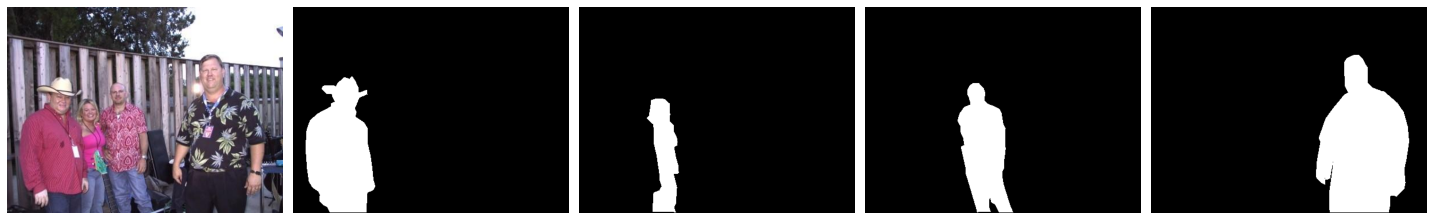

In [ ]:
f = 'ADE_train_00014301'

im = read(find(f, all_images), 1)
an = read(find(f, all_annots), 1).transpose(2,0,1)
r,g,b = an
nzs = np.nonzero(r==4) # 4 stands for person
instances = np.unique(g[nzs])
masks = np.zeros((len(instances), *r.shape))
for ix,_id in enumerate(instances):
    masks[ix] = g==_id

subplots([im, *masks], sz=20)

In [ ]:
annots = []
for ann in Tqdm(all_annots):
    _ann = read(ann, 1).transpose(2,0,1)
    r,g,b = _ann
    if 4 not in np.unique(r): continue
    annots.append(ann)

100%|██████████| 20210/20210 [01:58<00:00, 170.02it/s]


In [ ]:
from sklearn.model_selection import train_test_split
_annots = stems(annots)
trn_items, val_items = train_test_split(_annots, random_state=2)

In [ ]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N):
        self.items = items
        self.transforms = transforms
        self.N = N
    def get_mask(self, path):
        an = read(path, 1).transpose(2,0,1)
        r,g,b = an
        nzs = np.nonzero(r==4)
        instances = np.unique(g[nzs])
        masks = np.zeros((len(instances), *r.shape))
        for ix,_id in enumerate(instances):
            masks[ix] = g==_id
        return masks
    def __getitem__(self, ix):
        _id = self.items[ix]
        img_path = f'images/training/{_id}.jpg'
        mask_path = f'annotations_instance/training/{_id}.png'
        masks = self.get_mask(mask_path)
        obj_ids = np.arange(1, len(masks)+1)
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i])
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([ix])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    def __len__(self):
        return self.N
    def choose(self):
        return self[randint(len(self))]

2020-11-07 13:21:42.495 | INFO     | torch_snippets.loader:subplots:375 - plotting 2 images in a grid of 1x2 @ (5, 5)


Tensor	Shape: torch.Size([3, 683, 512])	Min: 0.000	Max: 1.000	Mean: 0.469	dtype: torch.float32
Dict Of 6 items
	BOXES:
	Tensor	Shape: torch.Size([1, 4])	Min: 468.000	Max: 599.000	Mean: 531.500	dtype: torch.float32
	LABELS:
	Tensor	Shape: torch.Size([1])	Min: 1.000	Max: 1.000	Mean: 1.000	dtype: torch.int64
	MASKS:
	Tensor	Shape: torch.Size([1, 683, 512])	Min: 0.000	Max: 1.000	Mean: 0.000	dtype: torch.uint8
	IMAGE_ID:
	Tensor	Shape: torch.Size([1])	Min: 0.000	Max: 0.000	Mean: 0.000	dtype: torch.int64
	AREA:
	Tensor	Shape: torch.Size([1])	Min: 180.000	Max: 180.000	Mean: 180.000	dtype: torch.float32
... ... 1 more items


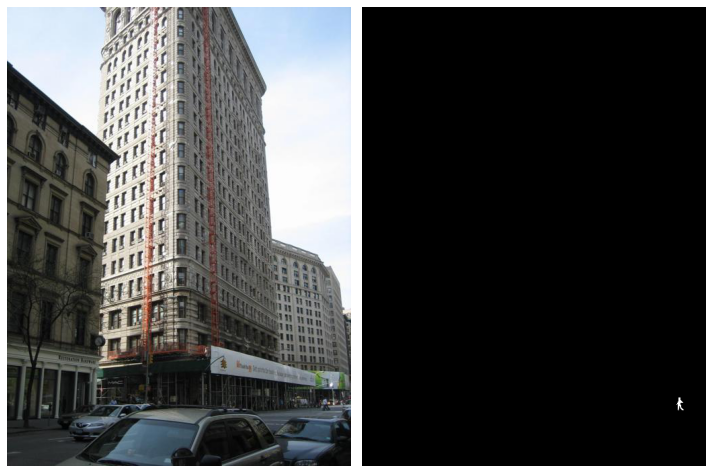

In [ ]:
x = MasksDataset(trn_items, get_transform(train=True), N=100)
im,targ = x[0]
inspect(im,targ)
subplots([im, *targ['masks']], sz=10)

In [ ]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,num_classes)
    return model

In [ ]:
model = get_model_instance_segmentation(2).to(device)
model

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [ ]:
dataset = MasksDataset(trn_items, get_transform(train=True), N=3000)
dataset_test = MasksDataset(val_items, get_transform(train=False), N=800)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [ ]:
num_classes = 2
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [ ]:
num_epochs = 5

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    res = evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [   0/1500]  eta: 0:27:42  lr: 0.000010  loss: 4.2739 (4.2739)  loss_classifier: 0.6073 (0.6073)  loss_box_reg: 0.3803 (0.3803)  loss_mask: 3.2363 (3.2363)  loss_objectness: 0.0270 (0.0270)  loss_rpn_box_reg: 0.0231 (0.0231)  time: 1.1083  data: 0.1448  max mem: 2529
Epoch: [0]  [  10/1500]  eta: 0:18:26  lr: 0.000060  loss: 4.1763 (3.9332)  loss_classifier: 0.6484 (0.6451)  loss_box_reg: 0.3803 (0.3738)  loss_mask: 2.8169 (2.8463)  loss_objectness: 0.0270 (0.0445)  loss_rpn_box_reg: 0.0185 (0.0235)  time: 0.7428  data: 0.1487  max mem: 2863
Epoch: [0]  [  20/1500]  eta: 0:17:14  lr: 0.000110  loss: 2.4081 (2.9151)  loss_classifier: 0.5345 (0.5310)  loss_box_reg: 0.2859 (0.3353)  loss_mask: 1.6489 (1.9899)  loss_objectness: 0.0216 (0.0362)  loss_rpn_box_reg: 0.0077 (0.0227)  time: 0.6784  data: 0.1163  max mem: 3269
Epoch: [0]  [  30/1500]  eta: 0:17:17  lr: 0.000160  loss: 1.4596 (2.3763)  loss_classifier: 0.3194 (0.4435)  loss_box_reg: 0.2881 (0.3487)  loss_mask: 0.6758 (

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
plt.title('Training Loss')
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)

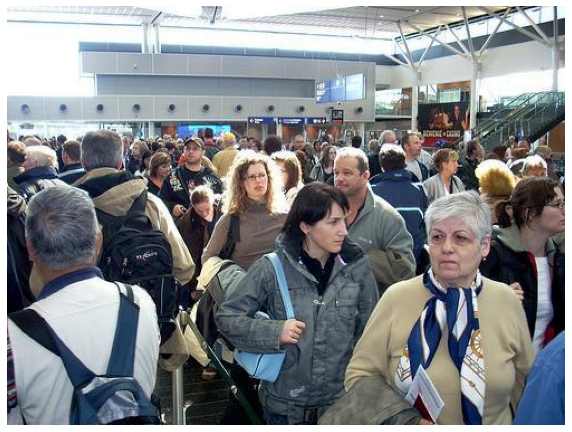

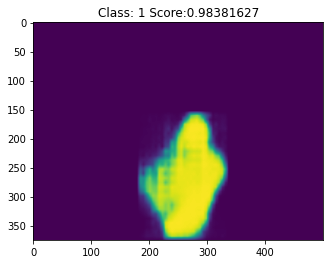

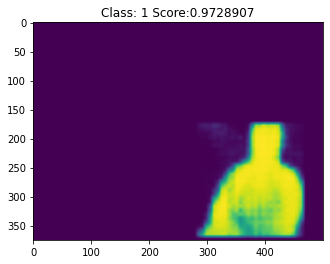

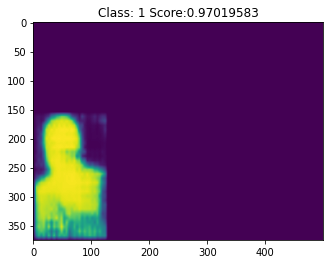

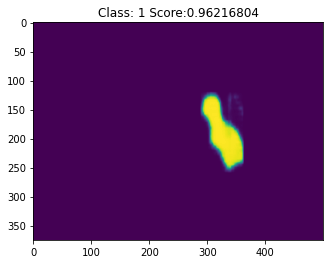

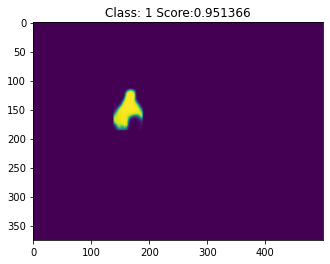

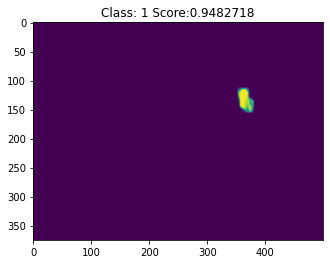

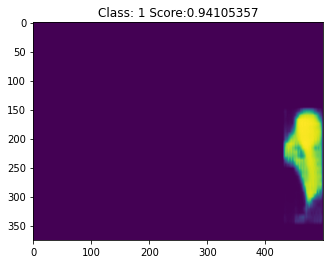

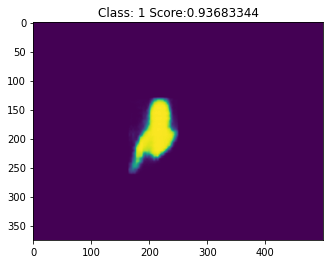

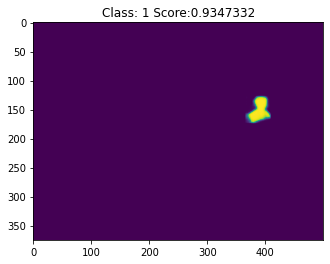

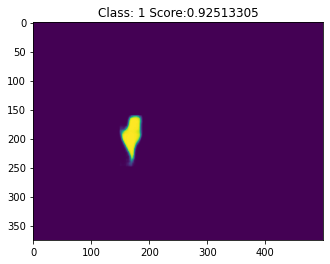

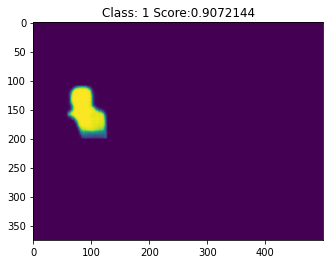

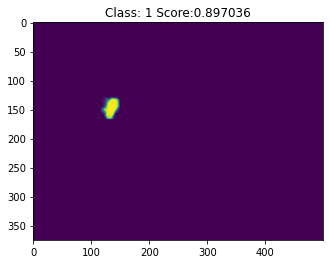

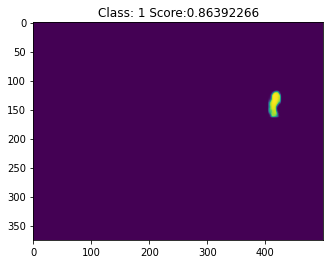

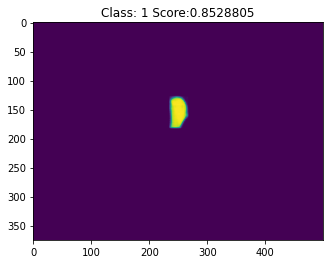

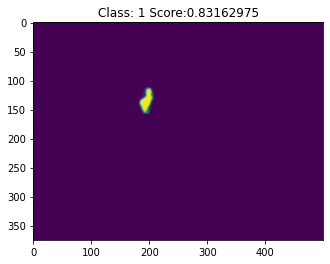

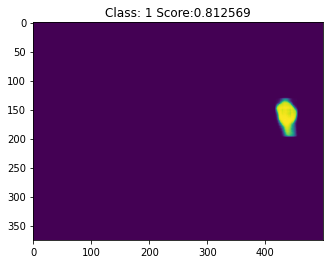

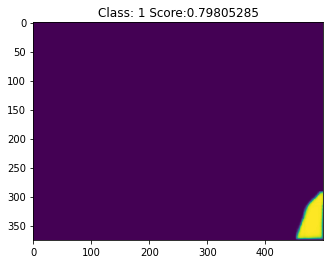

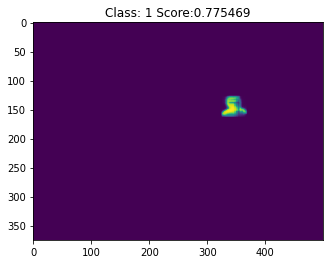

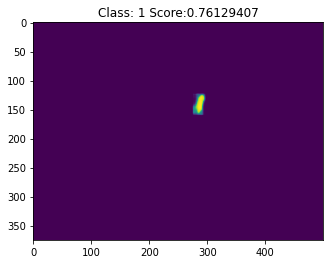

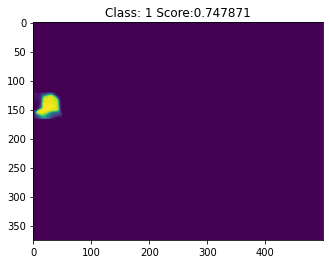

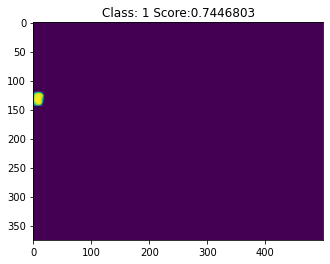

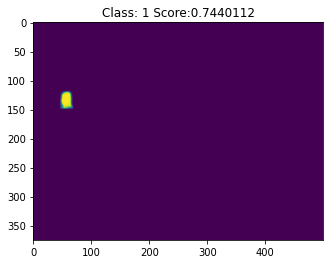

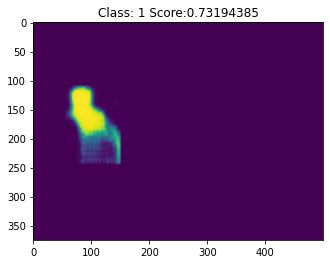

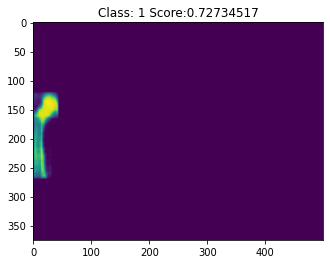

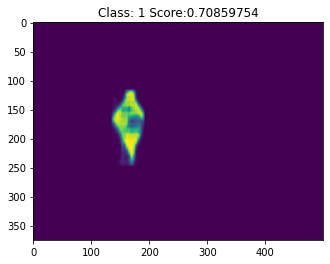

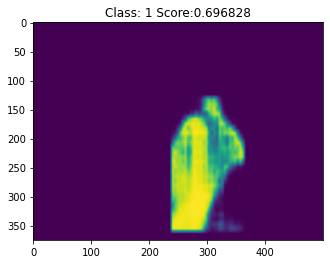

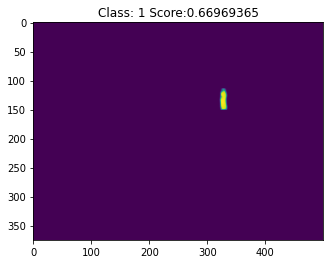

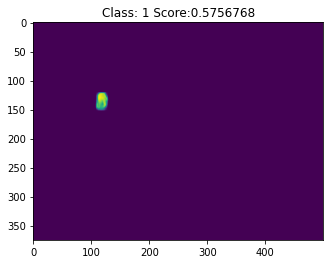

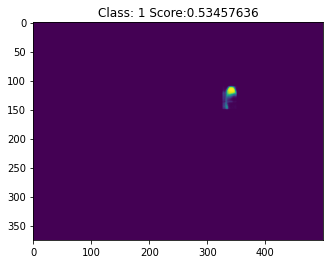

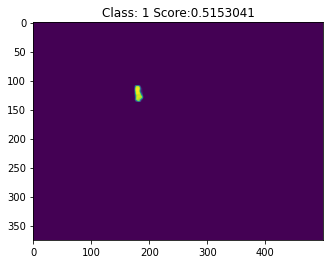

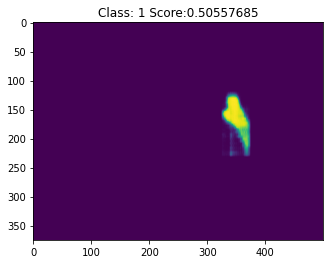

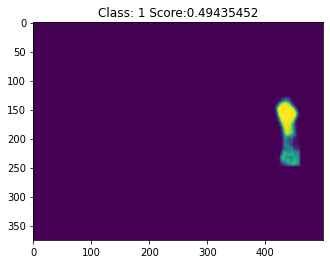

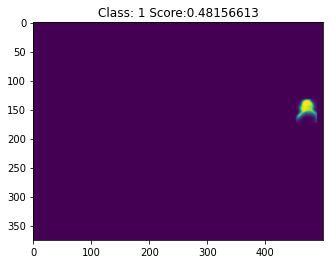

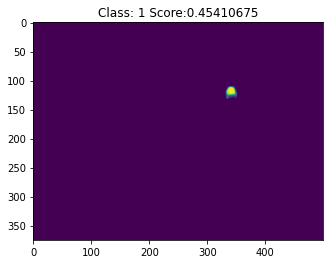

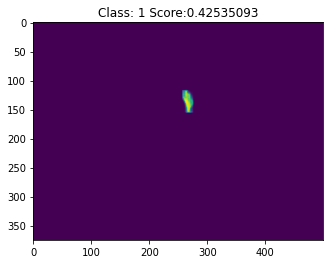

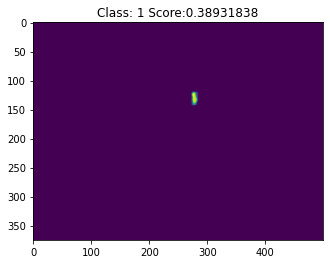

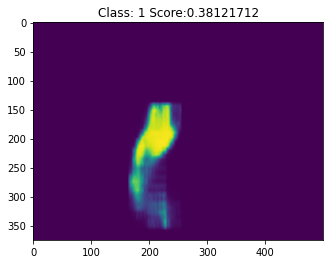

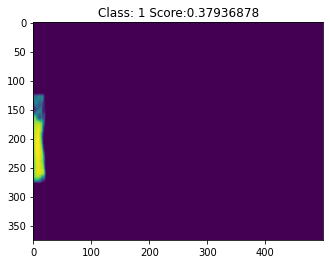

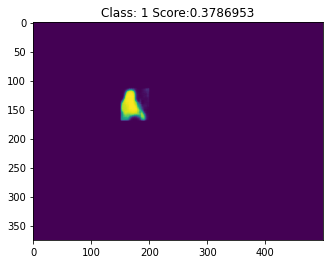

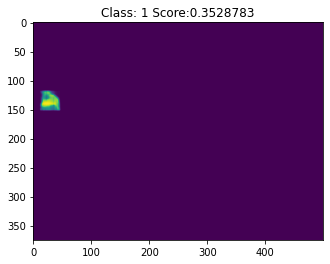

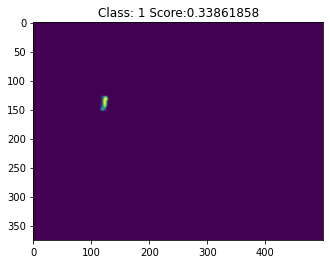

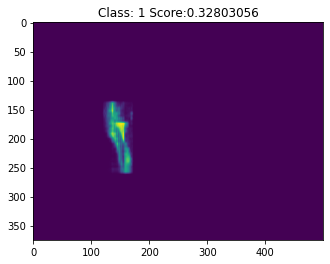

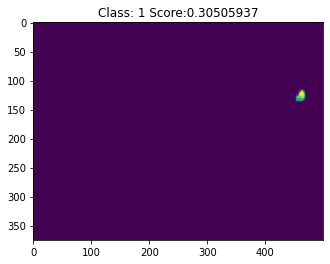

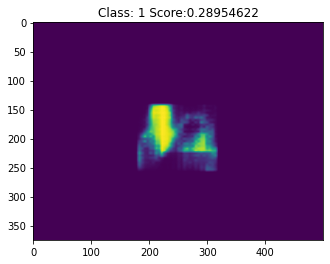

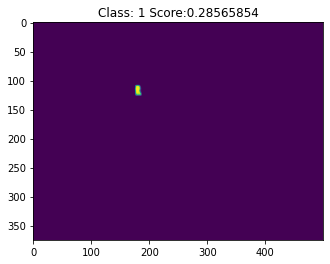

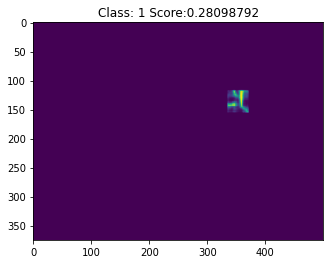

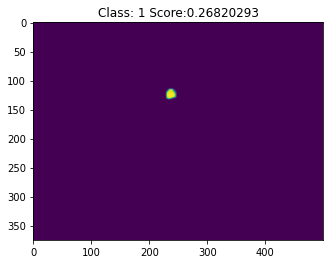

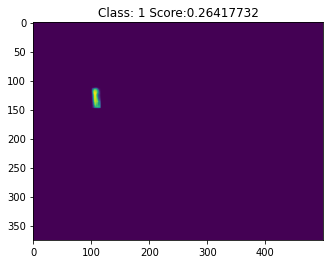

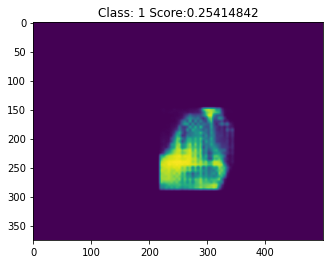

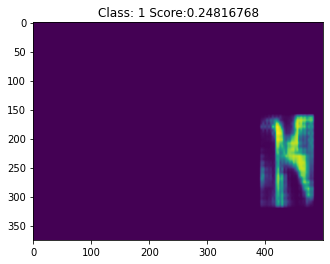

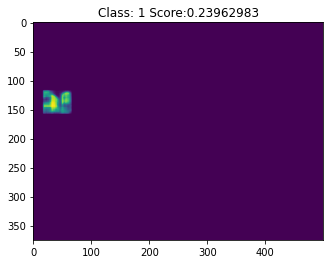

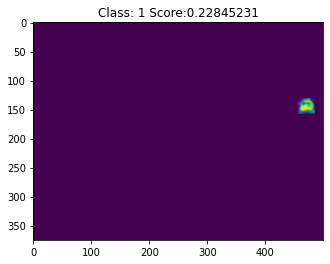

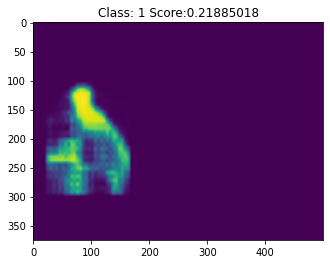

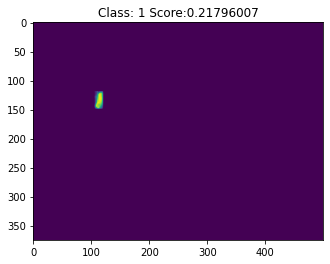

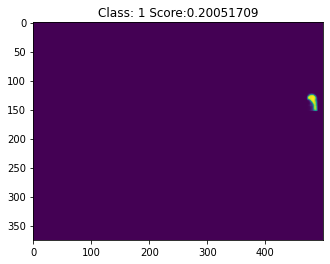

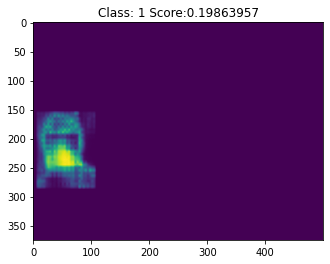

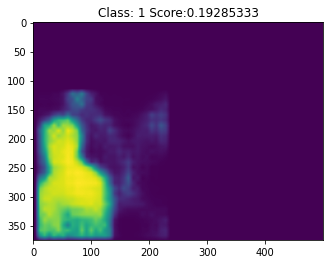

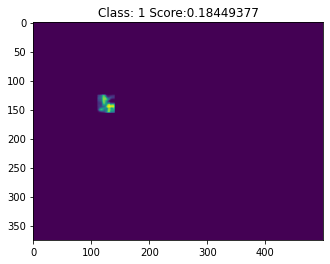

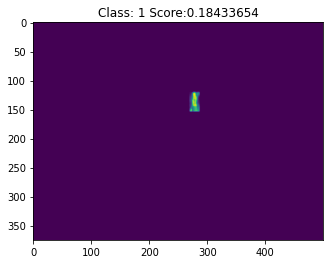

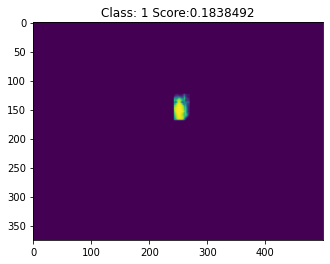

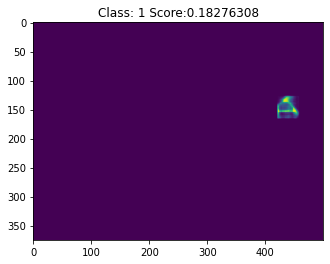

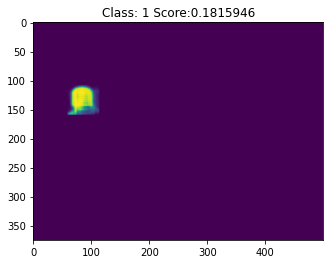

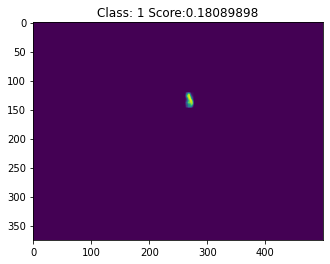

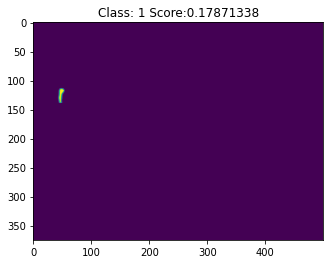

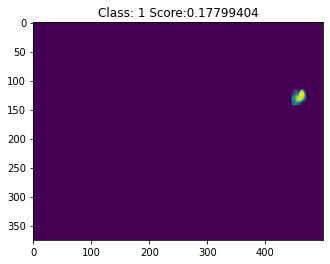

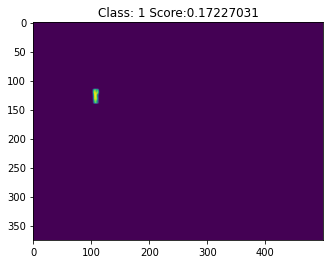

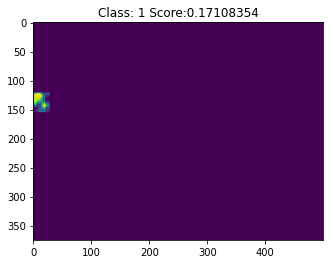

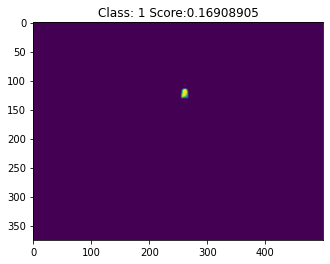

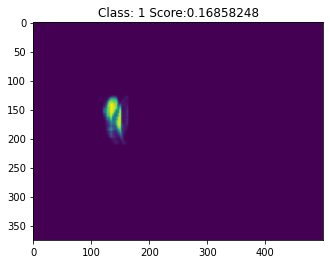

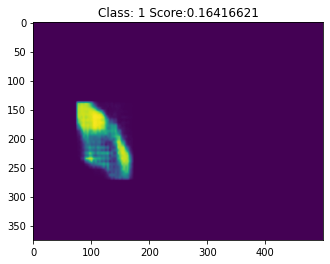

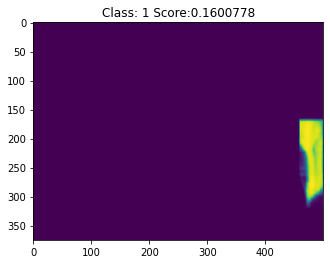

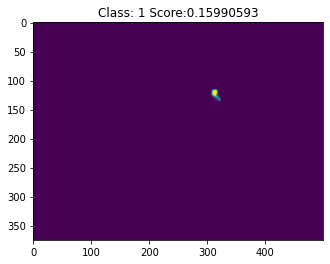

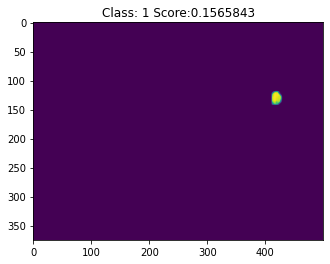

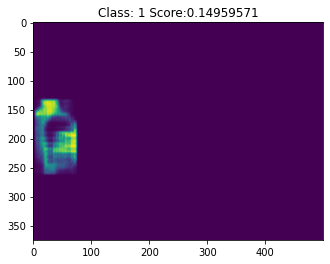

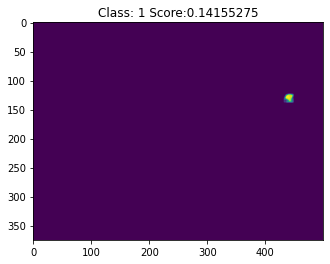

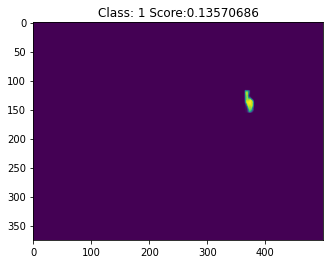

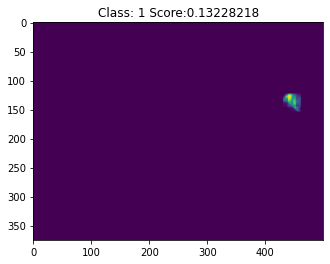

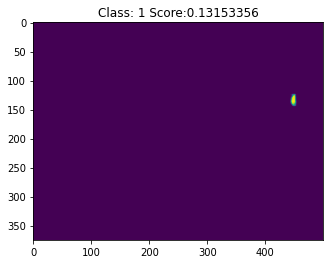

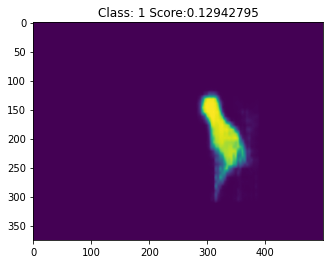

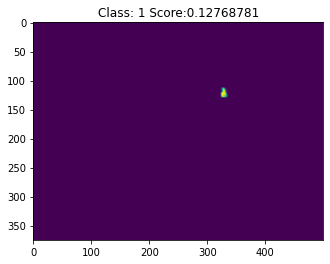

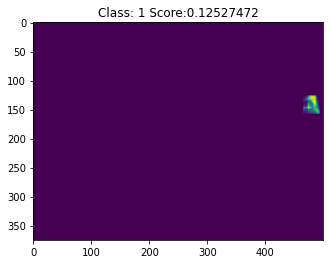

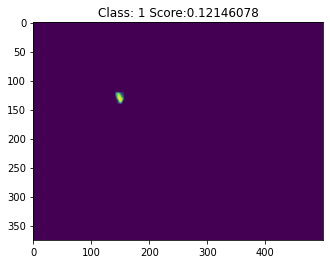

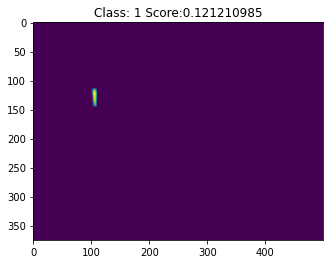

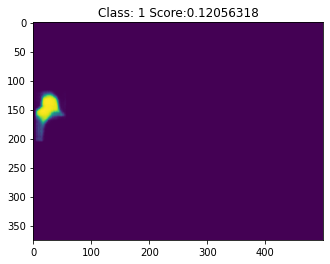

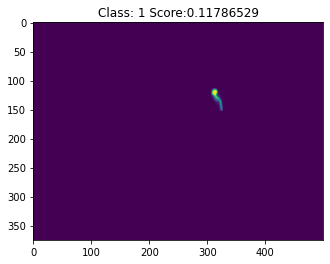

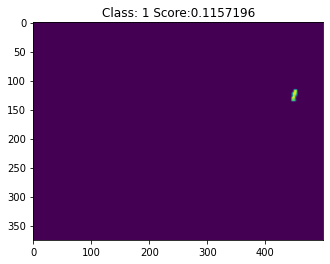

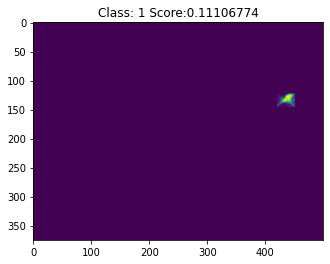

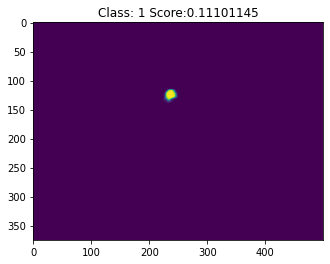

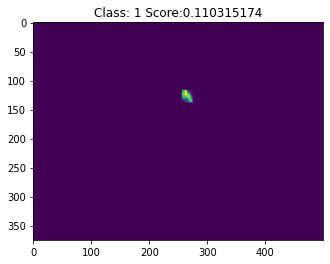

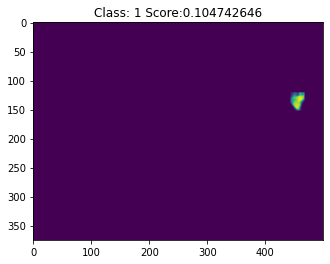

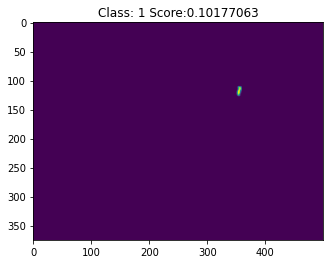

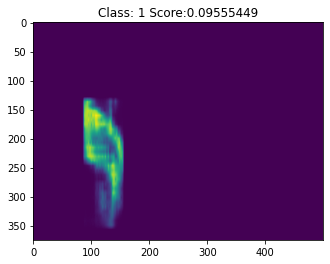

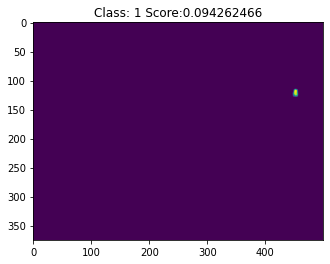

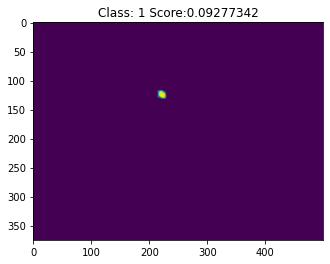

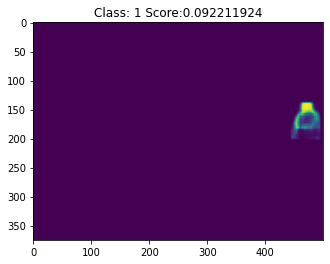

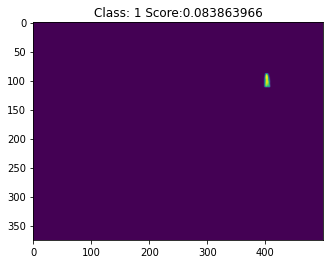

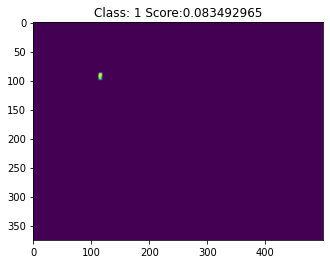

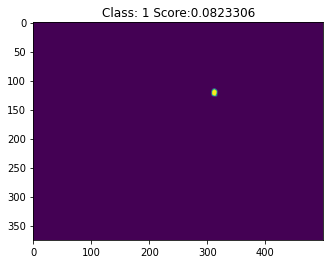

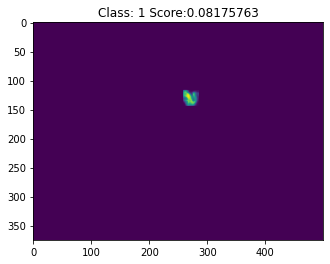

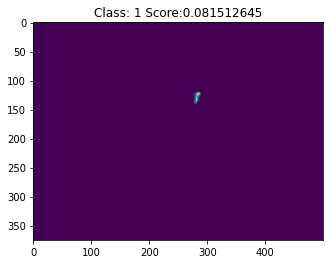

In [ ]:
model.eval()
im = dataset_test[0][0]
show(im)
with torch.no_grad():
    prediction = model([im.to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
        plt.show()